In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
# Function borrowed from DeepLearning.AI assignment autograder (Andrew Ng)
# Used only for internal testing – not part of final model


# Compare the two inputs
def comparator(learner, instructor):
    for a, b in zip(learner, instructor):
        if tuple(a) != tuple(b):
            print(colored("Test failed", attrs=['bold']),
                  "\n Expected value \n\n", colored(f"{b}", "green"),
                  "\n\n does not match the input value: \n\n",
                  colored(f"{a}", "red"))
            raise AssertionError("Error in test")
    print(colored("All tests passed!", "green"))

def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []

    for layer in model.layers:
        # Handle InputLayer shape separately
        if layer.__class__.__name__ == 'InputLayer':
            descriptors = [layer.__class__.__name__, [tuple(layer.output.shape)], layer.count_params()]
        else:
            descriptors = [layer.__class__.__name__, tuple(layer.output.shape), layer.count_params()]

        # Add optional fields based on layer type
        if isinstance(layer, Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if isinstance(layer, MaxPooling2D):
            descriptors.append(layer.pool_size)
        if isinstance(layer, Dropout):
            descriptors.append(layer.rate)
        if isinstance(layer, Conv2DTranspose):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if isinstance(layer, Concatenate):
            pass  # no extra info needed

        result.append(descriptors)

    return result


def datatype_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += datatype_check(expected_output[key],
                                         target_output[key], error)
            except:
                print("Error: {} in variable {}. Got {} but expected type {}".format(error,
                                                                          key, type(target_output[key]), type(expected_output[key])))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try:
                success += datatype_check(expected_output[i],
                                         target_output[i], error)
            except:
                print("Error: {} in variable {}, expected type: {}  but expected type {}".format(error,
                                                                          i, type(target_output[i]), type(expected_output[i])))
        if success == len(target_output):
            return 1
        else:
            return 0

    else:
        assert isinstance(target_output, type(expected_output))
        return 1

def equation_output_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += equation_output_check(expected_output[key],
                                         target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error,
                                                                          key))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try:
                success += equation_output_check(expected_output[i],
                                         target_output[i], error)
            except:
                print("Error: {} for variable in position {}.".format(error, i))
        if success == len(target_output):
            return 1
        else:
            return 0

    else:
        if hasattr(target_output, 'shape'):
            np.testing.assert_array_almost_equal(target_output, expected_output)
        else:
            assert target_output == expected_output
        return 1

def shape_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += shape_check(expected_output[key],
                                         target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error, key))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try:
                success += shape_check(expected_output[i],
                                         target_output[i], error)
            except:
                print("Error: {} for variable {}.".format(error, i))
        if success == len(target_output):
            return 1
        else:
            return 0

    else:
        if hasattr(target_output, 'shape'):
            assert target_output.shape == expected_output.shape
        return 1

def single_test(test_cases, target):
    success = 0
    for test_case in test_cases:
        try:
            if test_case['name'] == "datatype_check":
                assert isinstance(target(*test_case['input']),
                                  type(test_case["expected"]))
                success += 1
            if test_case['name'] == "equation_output_check":
                assert np.allclose(test_case["expected"],
                                   target(*test_case['input']))
                success += 1
            if test_case['name'] == "shape_check":
                assert test_case['expected'].shape == target(*test_case['input']).shape
                success += 1
        except:
            print("Error: " + test_case['error'])

    if success == len(test_cases):
        print("\033[92m All tests passed.")
    else:
        print('\033[92m', success," Tests passed")
        print('\033[91m', len(test_cases) - success, " Tests failed")
        raise AssertionError("Not all tests were passed for {}. Check your equations and avoid using global variables inside the function.".format(target.__name__))

def multiple_test(test_cases, target):
    success = 0
    for test_case in test_cases:
        try:
            target_answer = target(*test_case['input'])
            if test_case['name'] == "datatype_check":
                success += datatype_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "equation_output_check":
                success += equation_output_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "shape_check":
                success += shape_check(test_case['expected'], target_answer, test_case['error'])
        except:
            print("Error: " + test_case['error'])

    if success == len(test_cases):
        print("\033[92m All tests passed.")
    else:
        print('\033[92m', success," Tests passed")
        print('\033[91m', len(test_cases) - success, " Tests failed")
        raise AssertionError("Not all tests were passed for {}. Check your equations and avoid using global variables inside the function.".format(target.__name__))




In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kumaresanmanickavelu/lyft-udacity-challenge")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lyft-udacity-challenge


In [5]:
contents=os.listdir(path)
for item in contents:
    print(item)

dataB
datab
dataD
datad
dataA
dataa
dataC
datac
dataE
datae


In [7]:
image_path='/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB'
mask_path='/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg'

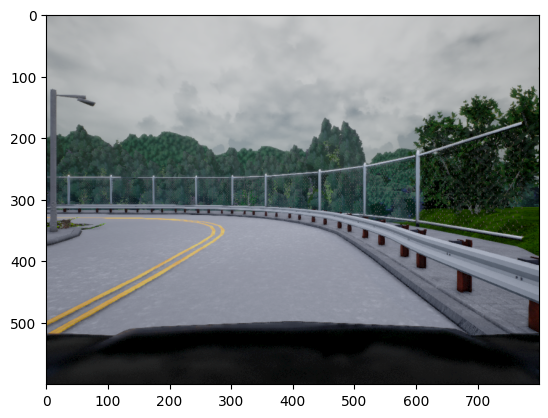

F6-50.png


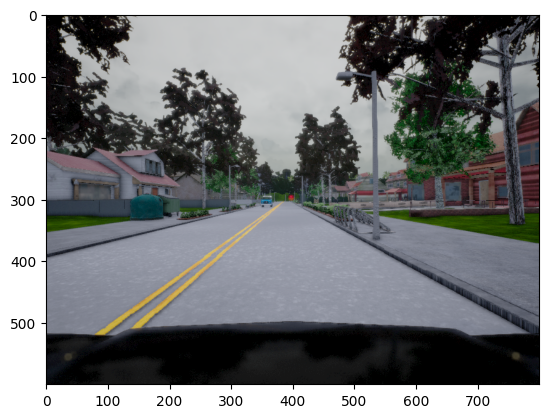

F2-90.png


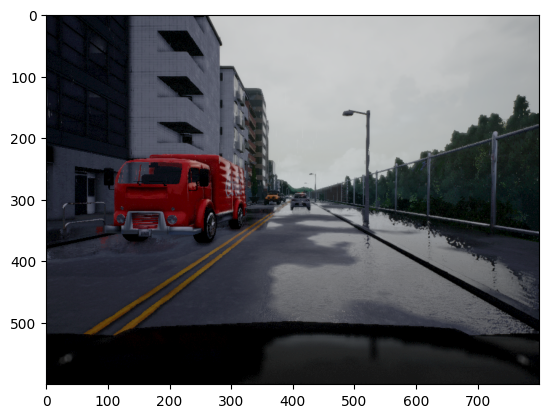

02_00_161.png


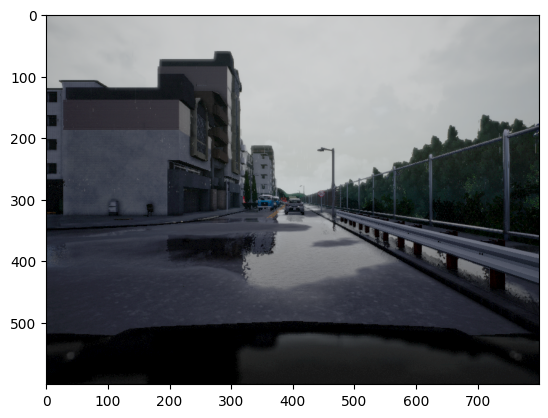

02_00_090.png


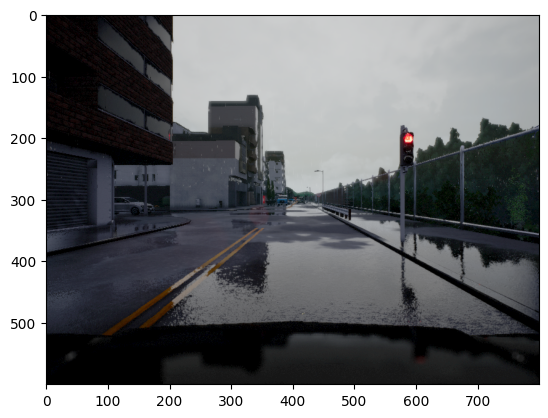

02_00_040.png


In [8]:
new_dir=os.listdir(image_path)
for item in new_dir[:5]:
  img=plt.imread(image_path+'/'+item)
  plt.imshow(img)
  plt.show()
  print(item)

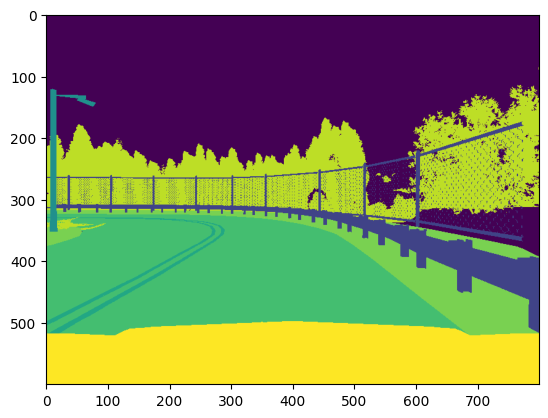

F6-50.png


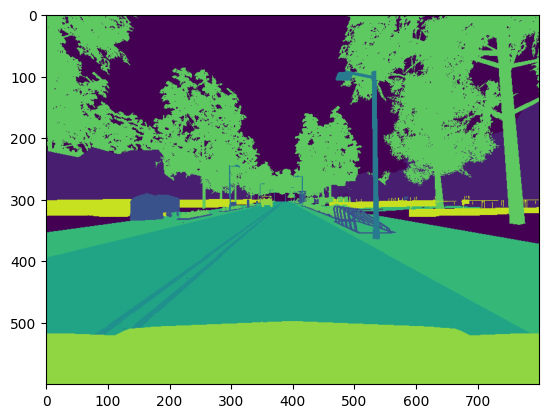

F2-90.png


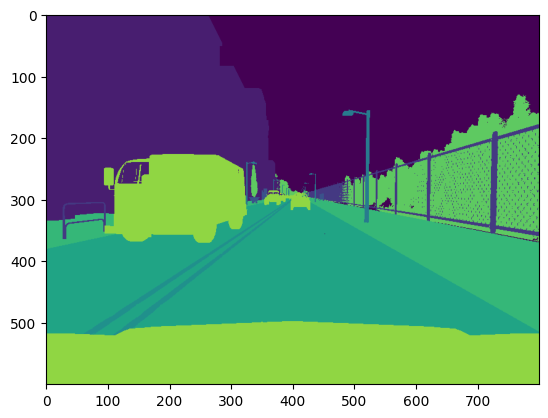

02_00_161.png


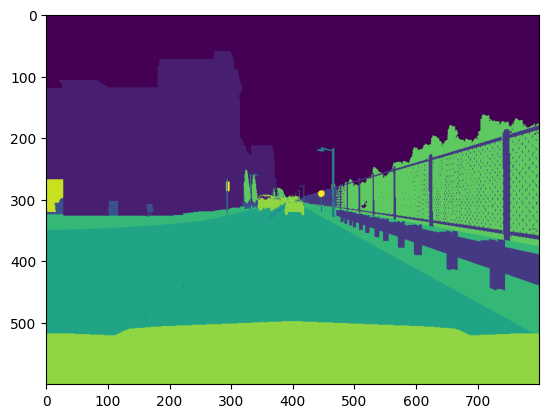

02_00_090.png


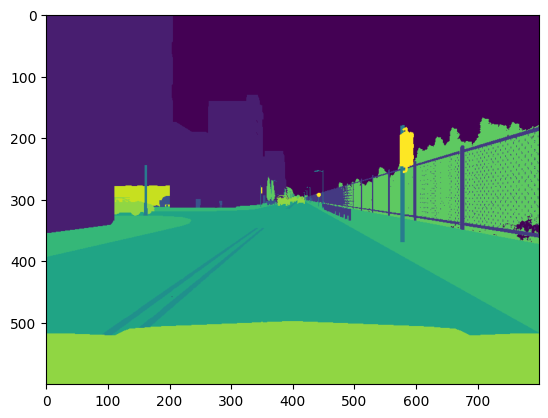

02_00_040.png


In [9]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
new_mask_dir=os.listdir(mask_path)
for item in new_mask_dir[:5]:
  img=imageio.imread(mask_path+'/'+item)
  img=img[:,:,0]
  plt.imshow(img)
  plt.show()
  print(item)

In [10]:
image_list=[image_path+'/'+item for item in new_dir]
mask_list=[mask_path+'/'+item for item in new_mask_dir]


In [11]:
len(image_list)

1000

In [12]:

len(mask_list)

1000

## Check out some of the unmasked and masked images

Text(0.5, 1.0, 'Segmentation')

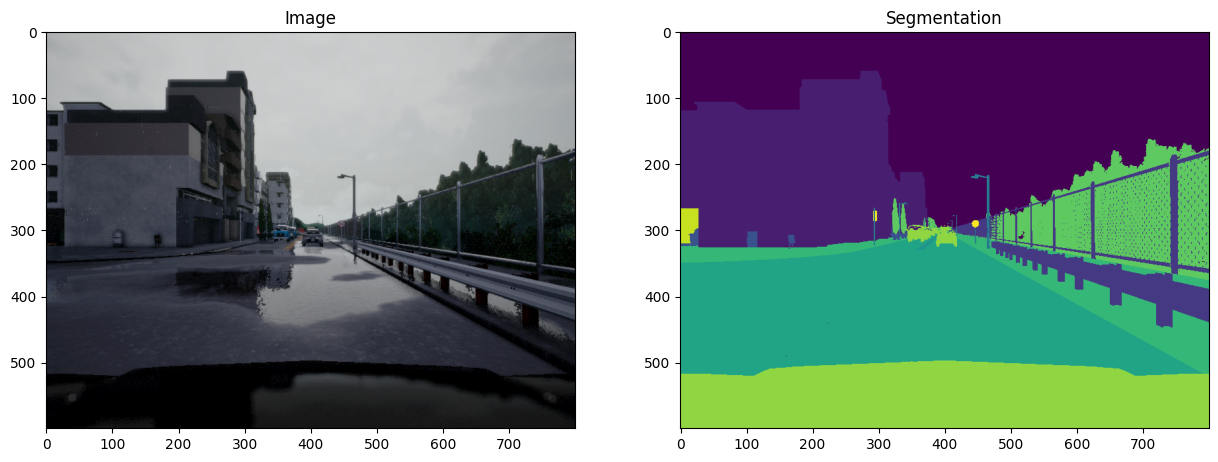

In [14]:
N=3
img=imageio.imread(image_list[N])
mask=imageio.imread(mask_list[N])
fig,arr=plt.subplots(1,2,figsize=(15,15))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:,:,0])
arr[1].set_title('Segmentation')

# Spilt the Dataset into Unmasked and Masked Images

In [18]:
image_list_ds=tf.data.Dataset.from_tensor_slices(image_list)
mask_list_ds=tf.data.Dataset.from_tensor_slices(mask_list)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
  print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F6-50.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F6-50.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F2-90.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F2-90.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_161.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_161.png'>)


In [19]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image,mask in dataset.take(1):
  print(image)
  print(mask)

tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F6-50.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F6-50.png', shape=(), dtype=string)


# Processing the data

In [30]:
def process_path(image_path, mask_path):
  # Loads and prepares an image and its mask for training (normalizes image, flattens mask)

  img=tf.io.read_file(image_path)
  img=tf.image.decode_png(img,channels=3)
  img=tf.image.convert_image_dtype(img,tf.float32)

  mask=tf.io.read_file(mask_path)
  mask=tf.image.decode_png(mask,channels=3)
  mask=tf.math.reduce_max(mask,axis=-1,keepdims=True)
  return img,mask

In [31]:
def preprocess(image, mask):
  # Resizes image and mask to 128×128 and normalizes image pixels to [0, 1] for model input

  input_image=tf.image.resize(image, (96, 128), method='nearest')
  input_mask=tf.image.resize(mask, (96, 128), method='nearest')


  return input_image, input_mask

In [32]:
image_ds=dataset.map(process_path)
processed_image_ds=image_ds.map(preprocess)

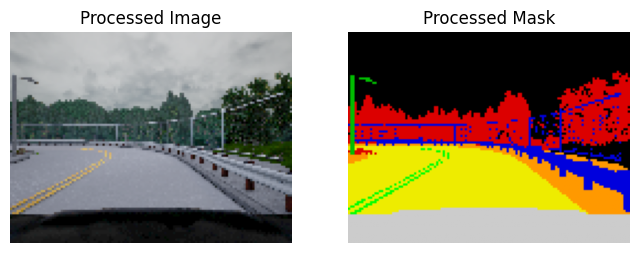

In [33]:
import matplotlib.pyplot as plt

# Take one sample from the processed dataset
for image, mask in processed_image_ds.take(1):
    plt.figure(figsize=(8, 4))

    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy())
    plt.title("Processed Image")
    plt.axis('off')

    # Show the mask
    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(mask).numpy(), cmap='nipy_spectral')
    plt.title("Processed Mask")
    plt.axis('off')

    plt.show()


In [34]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

  conv=Conv2D(n_filters,
              3,
              activation='relu',
              padding='same',
              kernel_initializer='he_normal')(inputs)
  conv=Conv2D(n_filters,
              3,
              activation='relu',
              padding='same',
              kernel_initializer='he_normal')(conv)
  # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
  if dropout_prob > 0:
    conv=Dropout(dropout_prob)(conv)
 # if max_pooling is True add a MaxPooling2D with 2x2 pool_size

  if max_pooling:
    next_layer=MaxPooling2D((2,2))(conv)
  else:
    next_layer=conv
  skip_connection=conv
  return next_layer, skip_connection

#### params = (kernel_height × kernel_width × input_channels + 1) × number_of_filters


In [47]:
input_size=(96,128,3)
n_filters=32
inputs=Input(input_size)
cblock1=conv_block(inputs, n_filters*1) # block 1 so 1, if block 2 then 2
model1=tf.keras.Model(inputs=inputs, outputs=cblock1)
output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', [(None, 96, 128, 32)], 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', [(None, 96, 128, 32)], 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', [(None, 48, 64, 32)], 0, (2, 2)]]

print('\nBlock 1:')
for layer in summary(model1):
    print(layer)

comparator(output1, summary(model1))

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', [(None, 96, 128, 1024)], 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', [(None, 96, 128, 1024)], 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', [(None, 96, 128, 1024)], 0, 0.1],
            ['MaxPooling2D', [(None, 48, 64, 1024)], 0, (2, 2)]]

print('\nBlock 2:')
for layer in summary(model2):
    print(layer)

comparator(summary(model2), output2)



Block 1:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', [(None, 96, 128, 32)], 896, 'same', 'relu', 'HeNormal']
['Conv2D', [(None, 96, 128, 32)], 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', [(None, 48, 64, 32)], 0, (2, 2)]
All tests passed!

Block 2:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', [(None, 96, 128, 1024)], 28672, 'same', 'relu', 'HeNormal']
['Conv2D', [(None, 96, 128, 1024)], 9438208, 'same', 'relu', 'HeNormal']
['Dropout', [(None, 96, 128, 1024)], 0, 0.1]
['MaxPooling2D', [(None, 48, 64, 1024)], 0, (2, 2)]
All tests passed!


In [49]:
def upsampling_block(expansive_inpput, contractive_input, n_filters=32):

  """
  Convolutional upsampling block

  Arguments:
      expansive_input -- Input tensor from previous layer
      contractive_input -- Input tensor from previous skip layer
      n_filters -- Number of filters for the convolutional layers
  Returns:
      conv -- Tensor output
  """
  up=Conv2DTranspose(
      n_filters,
      3,
      strides=(2,2),
      padding='same',
      kernel_initializer='he_normal')(expansive_inpput)
  merge=concatenate([up,contractive_input],axis=3)
  conv=Conv2D(n_filters,
              3,
              activation='relu',
              padding='same',
              kernel_initializer='he_normal')(merge)
  conv=Conv2D(n_filters,
              3,
              activation='relu',
              padding='same',
              kernel_initializer='he_normal')(conv)
  return conv

In [60]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 12, 16, 256)], 0],
           #below since strid is 2,2 so 12*2 and 16*2, for channels it is filter size=32
            ['Conv2DTranspose', (None, 24, 32, 32), 73760, 'same', 'linear', 'HeNormal'], # Added 'same', 'linear', 'HeNormal'
            ['InputLayer', [(None, 24, 32, 128)], 0],
            ['Concatenate', (None, 24, 32, 160), 0],
            ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

Block 1:
['InputLayer', [(None, 12, 16, 256)], 0]
['Conv2DTranspose', (None, 24, 32, 32), 73760, 'same', 'linear', 'HeNormal']
['InputLayer', [(None, 24, 32, 128)], 0]
['Concatenate', (None, 24, 32, 160), 0]
['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']
All tests passed!


# Building the Unet model

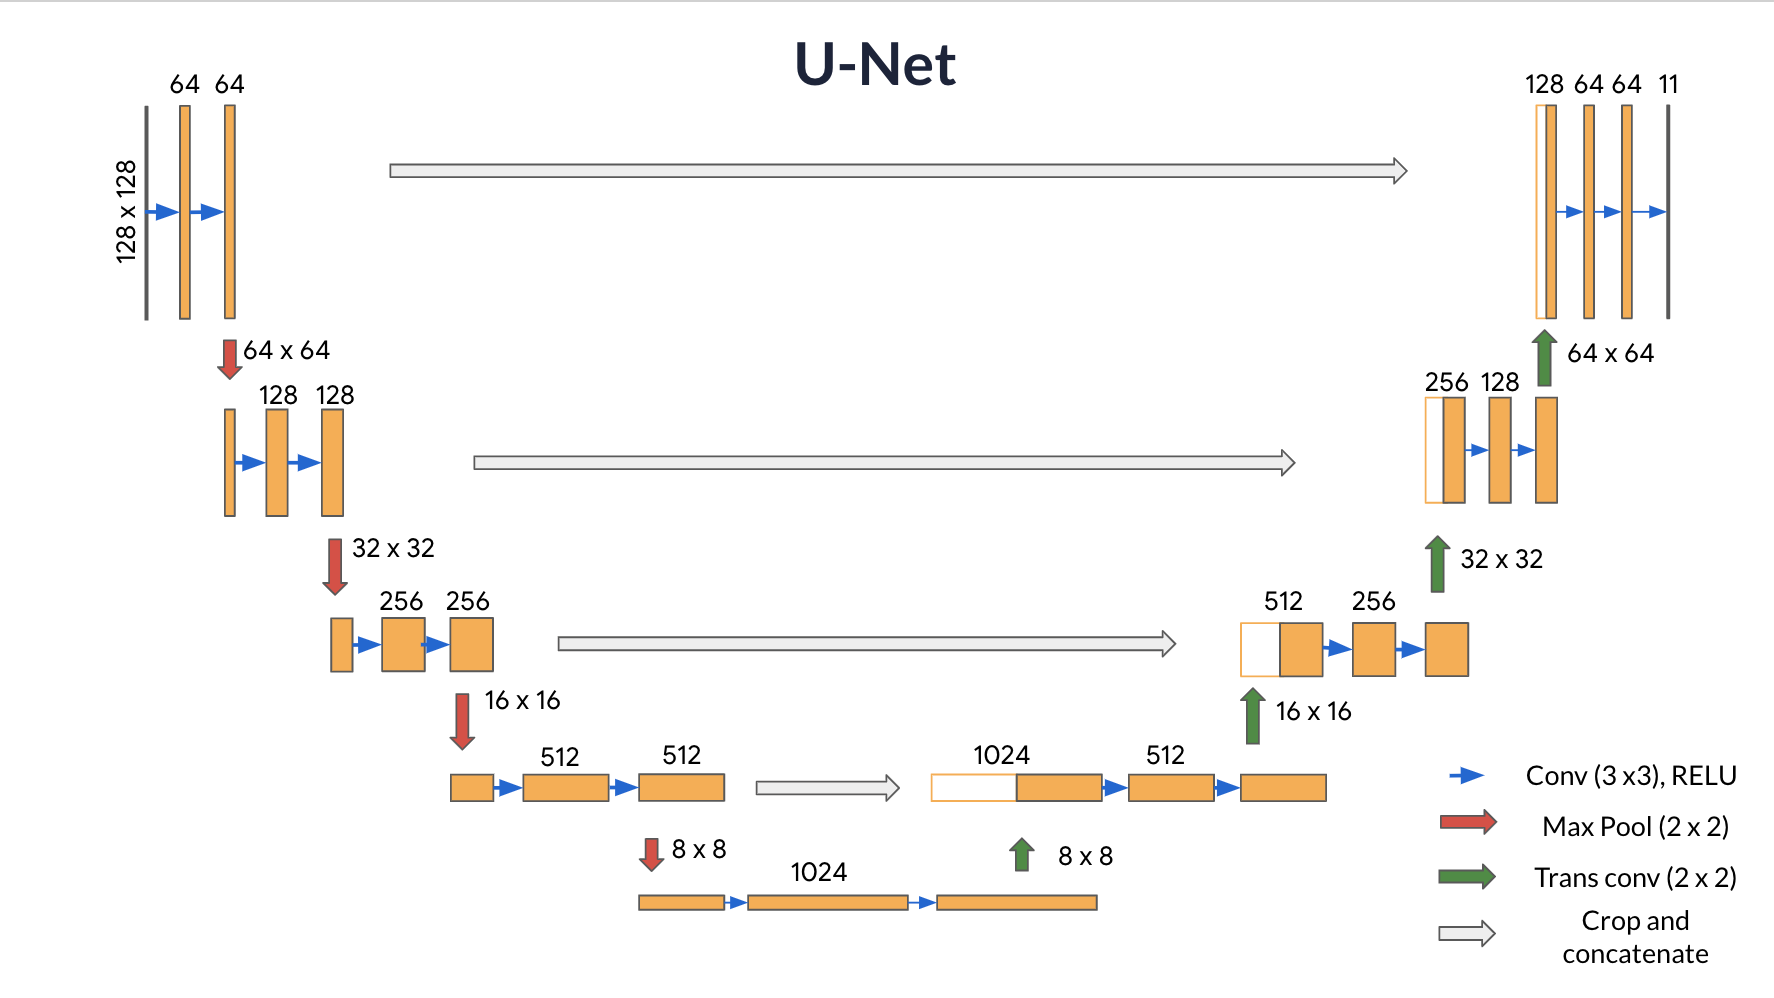

# There are 23 possible labels for each pixel in this self-driving car dataset.

In [76]:
def unet_model(input_size=(96,128,3),n_filters=32,n_classes=23):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    cblock1=conv_block(inputs=inputs,n_filters=n_filters)# 32
    cblock2=conv_block(inputs=cblock1[0],n_filters=n_filters*2)#32*2=64
    cblock3=conv_block(inputs=cblock2[0],n_filters=n_filters*4)#32*4=128
    cblock4=conv_block(inputs=cblock3[0],n_filters=n_filters*8,dropout_prob=0.3)#32*8=256
    cblock5=conv_block(inputs=cblock4[0],n_filters=n_filters*16,dropout_prob=0.3,max_pooling=False)#32*16=512
    # finished the encoding part
    # decoding start from here
    # the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6=upsampling_block(cblock5[0],cblock4[1],n_filters*8)
    ublock7=upsampling_block(ublock6,cblock3[1],n_filters*4)
    ublock8=upsampling_block(ublock7,cblock2[1],n_filters*2)
    ublock9=upsampling_block(ublock8,cblock1[1],n_filters)
    # finish decoding
    conv9=Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    conv10=Conv2D(n_classes,1,activation='softmax',padding='same')(conv9)

    model=tf.keras.Model(inputs=inputs,outputs=conv10)

    return model




In [77]:
img_height=96
img_width=128
num_channel=3
unet=unet_model((img_height,img_width,num_channel))


In [78]:
unet.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 96, 128,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 96, 128,   │        896 │ input_layer_31[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 96, 128,   │      9,248 │ conv2d_80[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 48, 64,    │          0 │ conv2d_81[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 48, 64,    │     18,496 │ max_pooling2d_19… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 48, 64,    │     36,928 │ conv2d_82[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 24, 32,    │          0 │ conv2d_83[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 24, 32,    │     73,856 │ max_pooling2d_20… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 24, 32,    │    147,584 │ conv2d_84[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 12, 16,    │          0 │ conv2d_85[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_86 (Conv2D)  │ (None, 12, 16,    │    295,168 │ max_pooling2d_21… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_87 (Conv2D)  │ (None, 12, 16,    │    590,080 │ conv2d_86[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 12, 16,    │          0 │ conv2d_87[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 6, 8, 256) │          0 │ dropout_6[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 6, 8, 512) │  1,180,160 │ max_pooling2d_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 6, 8, 512) │  2,359,808 │ conv2d_88[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 6, 8, 512) │          0 │ conv2d_89[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_17 │ (None, 12, 16,    │  1,179,904 │ dropout_7[0][0] 

 Total params: 8,640,471 (32.96 MB)

 Trainable params: 8,640,471 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
unet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Dataset Handeling

#### Below, define a function that allows us to display both an input image, and its ground truth: the true mask. The true mask is what our trained model output is aiming to get as close to as possible

In [80]:
def display(display_list):
    plt.figure(figsize=(15,15))
    title=['Input Image','True Mask','Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1,len(display_list),i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


(600, 800, 1)


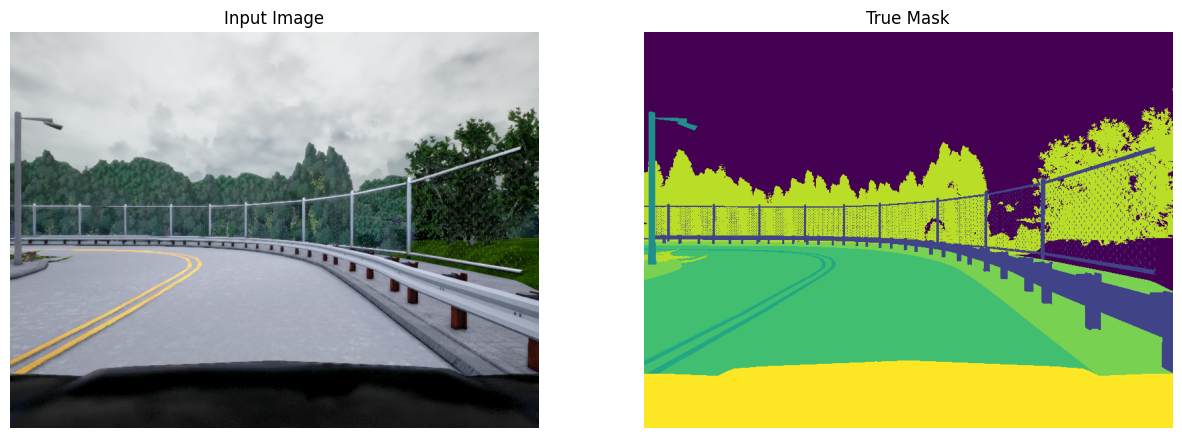

In [81]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


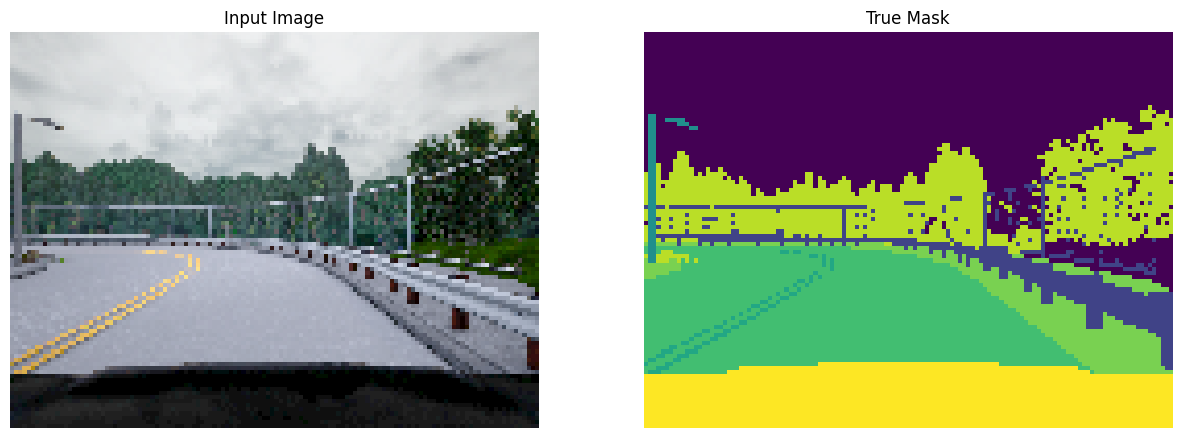

In [82]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

# Train the Model

In [83]:
EPOCHS=50
VAL_SUBSPLITS=5
BUFFER_SIZE=500 # Shuffle 500 samples at a time
BATCH_SIZE=32 # Use 32 samples per batch
processed_image_ds.batch(BATCH_SIZE)
train_dataset=processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history=unet.fit(train_dataset,epochs=EPOCHS)


(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 365ms/step - accuracy: 0.2742 - loss: 2.5015
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.6268 - loss: 1.1310
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.7819 - loss: 0.6618
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.8240 - loss: 0.5395
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.8564 - loss: 0.4588
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8562 - loss: 0.4626
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.8852 - loss: 0.3753
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8971 - loss: 0.3340
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9073 - loss: 0.2988
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9147 - loss: 0.2742
Epoch 11/50
32/32

# Creating Predicted Mask

In [84]:
def create_mask(pred_mask):
  pred_mask=tf.argmax(pred_mask,axis=-1)
  pred_mask=pred_mask[...,tf.newaxis]
  return pred_mask[0]

# Plot Model Accuracy

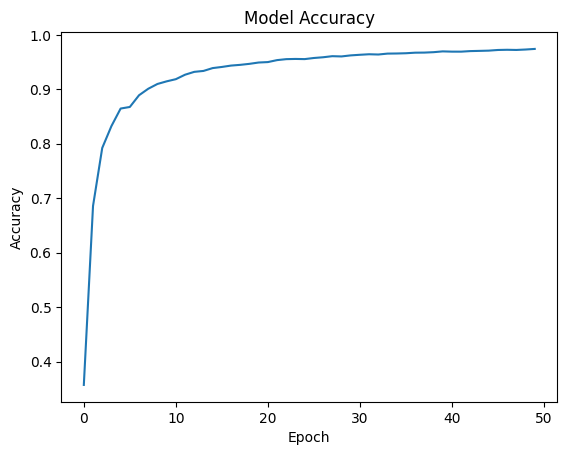

In [85]:
plt.plot(model_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Show prediction

In [86]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


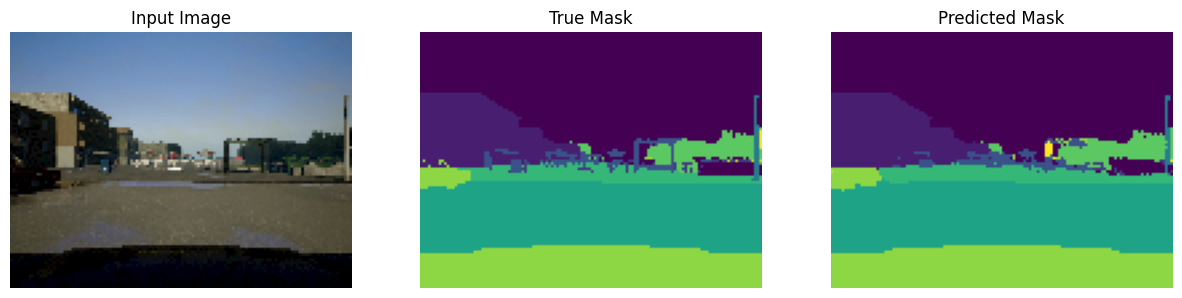

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


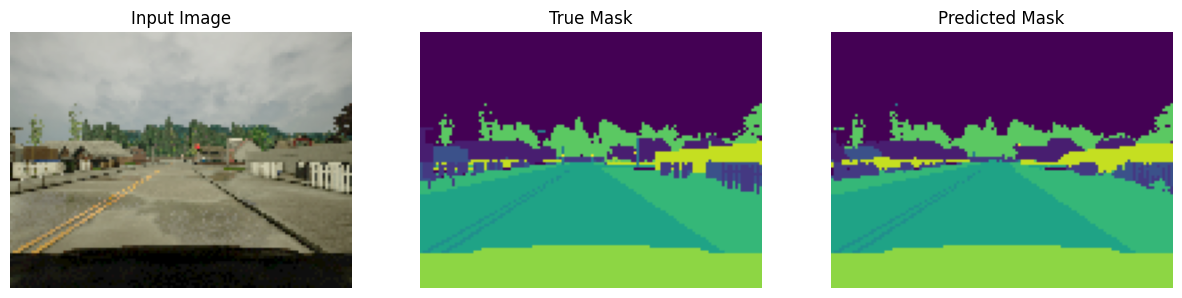

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


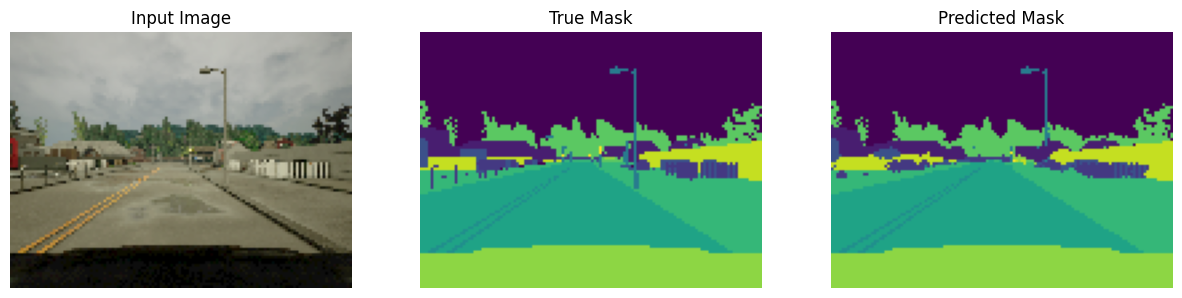

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


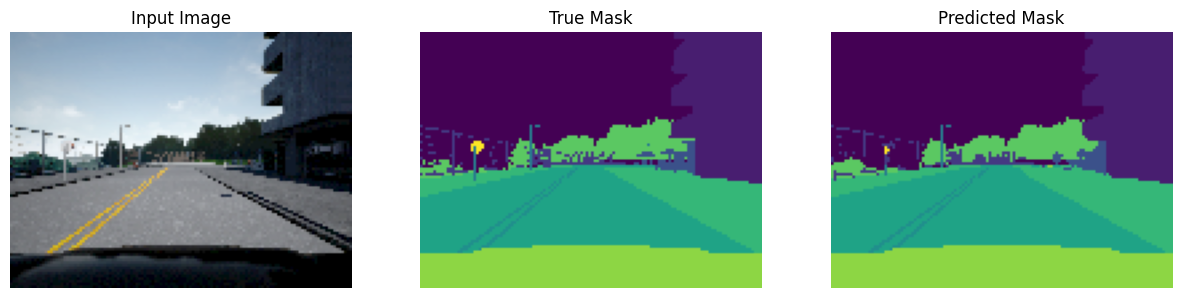

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


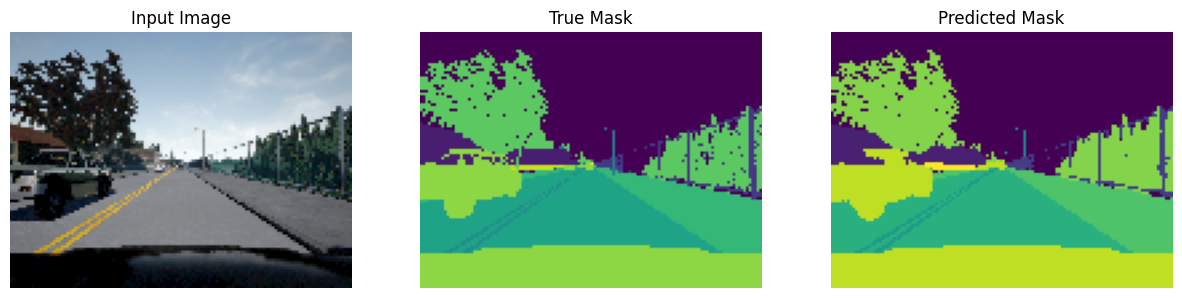

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


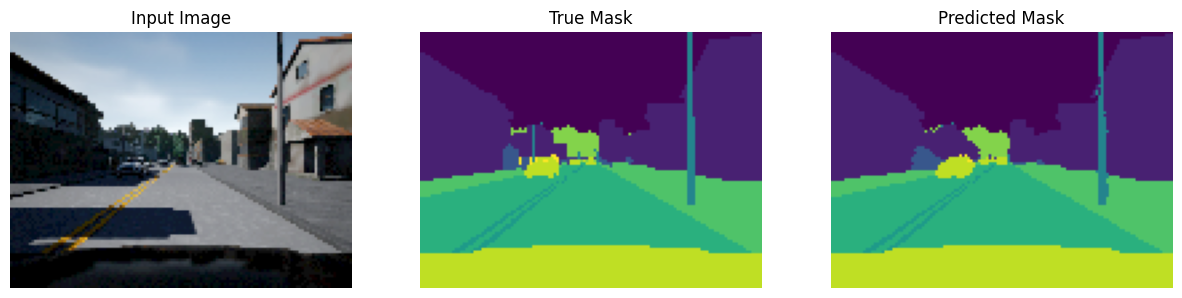

In [87]:
show_predictions(train_dataset, 6)

1. Semantic image segmentation predicts a label for every single pixel in an image
2. U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
3. Skip connections are used to prevent border pixel information loss and overfitting in U-Ne

In [90]:
# save the model as keras
unet.save('/content/drive/MyDrive/sementic_segmentation/unet_model.keras')